# Imports

In [1]:
import gdown
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Data Preprocessing

In [2]:
# Define the file ID and destination
file_id = '14m2XW31x_UWAqUeoM0SNVsH3kwyBIAVy'
destination = 'data.zip'

In [3]:
# Download the file from Google Drive
import gdown
gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=14m2XW31x_UWAqUeoM0SNVsH3kwyBIAVy
From (redirected): https://drive.google.com/uc?id=14m2XW31x_UWAqUeoM0SNVsH3kwyBIAVy&confirm=t&uuid=342f4061-d22c-4aaf-975a-c4a335805066
To: /content/data.zip
100%|██████████| 2.48G/2.48G [00:30<00:00, 82.2MB/s]


'data.zip'

In [4]:
# Unzip the downloaded file
!unzip -q 'data'.zip -d /content/

In [5]:
# Define data augmentation and preprocessing for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Load and preprocess training and validation data
train_generator = datagen.flow_from_directory(
    '/content/data/train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
validation_generator = datagen.flow_from_directory(
    '/content/data/valid',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 6650 images belonging to 7 classes.
Found 1869 images belonging to 7 classes.


# Model Building

In [6]:
# Load pre-trained ResNet50
base_model = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3),
    pooling='max',
    classes=7,
    classifier_activation="softmax"
)

# Add custom classification head
x = base_model.output
predictions = Dense(7, activation='softmax')(x)

# Combine base model and custom head
model = Model(inputs=base_model.input, outputs=predictions)

# Make base model layers trainable
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [7]:
# Define EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=4,
    mode="auto",
    verbose=1,
    restore_best_weights=True
)

# Model Training

In [8]:
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
208/208 [==============================] - 305s 1s/step - loss: 0.9275 - accuracy: 0.8561 - val_loss: 4.8780 - val_accuracy: 0.1150
Epoch 2/10
208/208 [==============================] - 245s 1s/step - loss: 0.0956 - accuracy: 0.9789 - val_loss: 8.9439 - val_accuracy: 0.1429
Epoch 3/10
208/208 [==============================] - 245s 1s/step - loss: 0.0705 - accuracy: 0.9848 - val_loss: 10.3574 - val_accuracy: 0.1851
Epoch 4/10
208/208 [==============================] - 246s 1s/step - loss: 0.0544 - accuracy: 0.9878 - val_loss: 6.0963 - val_accuracy: 0.4601
Epoch 5/10
208/208 [==============================] - 243s 1s/step - loss: 0.0532 - accuracy: 0.9898 - val_loss: 2.4809 - val_accuracy: 0.7566
Epoch 6/10
208/208 [==============================] - 273s 1s/step - loss: 0.0326 - accuracy: 0.9916 - val_loss: 1.0515 - val_accuracy: 0.8898
Epoch 7/10
208/208 [==============================] - 240s 1s/step - loss: 0.0833 - accuracy: 0.9851 - val_loss: 1.2284 - val_accuracy: 0.880

# Model Evaluation

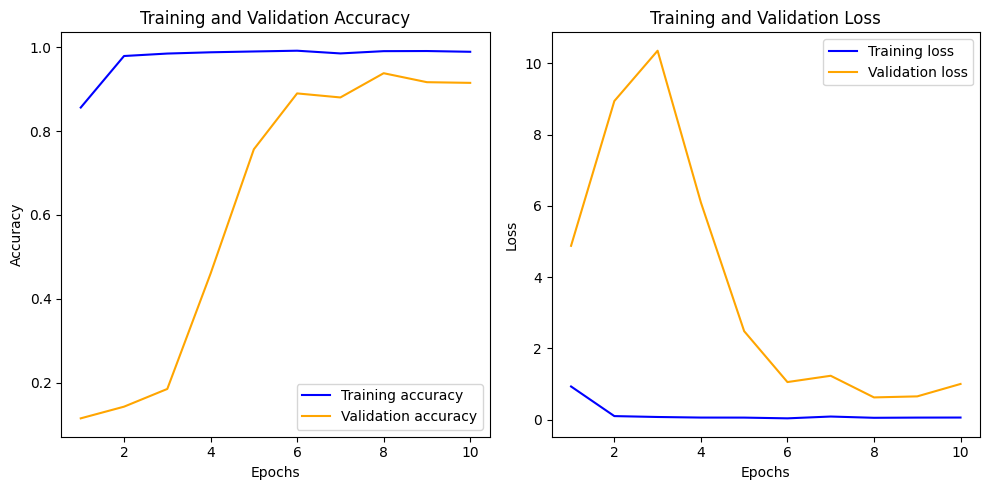

In [9]:
history_dict = history.history

# Extract acc and loss
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(acc_values) + 1)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the accuracy for training and validation data over epochs
ax[0].plot(epochs, acc_values, label='Training accuracy', color='blue') # Blue Line
ax[0].plot(epochs, val_acc_values, label='Validation accuracy', color='orange') # Orange Line
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

#Plot the Loss for training and validation data over epochs
ax[1].plot(epochs, loss_values, label='Training loss', color='blue') # Blue Line
ax[1].plot(epochs, val_loss_values, label='Validation loss', color='orange') # Orange Line
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()

In [10]:
testgen = ImageDataGenerator(
    rescale=1./255
)
test_generator = testgen.flow_from_directory(
    '/content/data/test',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',  # Change class_mode to 'categorical'
    shuffle=False
)

loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

Found 1869 images belonging to 7 classes.
59/59 [==============================] - 19s 323ms/step - loss: 1.7503 - accuracy: 0.8352
Test Loss: 1.7503
Test Accuracy: 83.52%


# Model Saving

In [12]:
model.save('resnet50_datasetbaru.h5')
# Alternative format
model.save('resnet50_datasetbaru.keras')